In [47]:
#----------------standard packages------------------
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#----------------caio's packages--------------------
import sys, os #add code folder to sys.path
#sys.path.append(os.path.abspath(os.path.join('..', 'code')))

#-------------------ML packages---------------------
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as xgb
#import xgboost as xgb

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc

match_data = pd.read_csv('../../../data/player_data.csv')

              precision    recall  f1-score   support

       False       0.52      0.91      0.66       154
        True       0.76      0.26      0.39       173

    accuracy                           0.57       327
   macro avg       0.64      0.58      0.53       327
weighted avg       0.65      0.57      0.52       327

Chasing Team Always Wins: ROC AUC = 0.500
Model Prediction: ROC AUC = 0.710


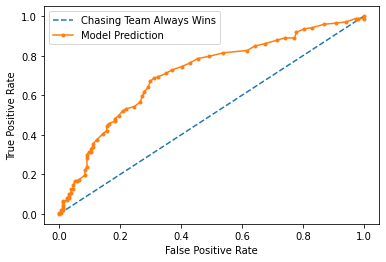

In [48]:
def cric_model(match_data, algorithm = 'forest'):
#-----------------preprocessing--------------------- 
    X, y = match_data.drop(['set_team_win', 'match_id'], axis = 1), match_data['set_team_win']
    
    #sampler = RandomUnderSampler(sampling_strategy = 'majority')
    #X, y = sampler.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = False)
    
    test_data = X_test.join(y_test).copy()
    
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

#------------------algorithms-----------------------      
    if algorithm == 'xgb':
        clf = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')
        clf.fit(X_train,y_train)
        xgb.plot_importance(clf,importance_type='weight')
        plt.show()
        print(pd.DataFrame.from_dict(clf.get_booster().get_fscore(),
                             orient = 'index').sort_values(0, ascending = False).head(10))  
    else:
        clf = RandomForestClassifier(random_state = 42)
        clf.fit(X_train, y_train)
    
    test_data['prob_set'] = clf.predict_proba(X_test)[:,1]
    test_data['prob_chase'] = clf.predict_proba(X_test)[:,0]
    y_pred = clf.predict(X_test)

#-------------------metrics-------------------------    
    accuracy = accuracy_score(y_test,y_pred)
    print(classification_report(y_test,y_pred))

    false_auc = roc_auc_score(y_test, y_test.clip(upper = False))
    model_auc = roc_auc_score(y_test, test_data['prob_set'])
    
    print('Chasing Team Always Wins: ROC AUC = %.3f' % (false_auc))
    print('Model Prediction: ROC AUC = %.3f' % (model_auc))
    
    false_fpr, false_tpr, _ = roc_curve(y_test, y_test.clip(upper = False))
    model_fpr, model_tpr, _ = roc_curve(y_test, test_data['prob_set'])

    plt.plot(false_fpr, false_tpr, linestyle = '--', label = 'Chasing Team Always Wins')
    plt.plot(model_fpr, model_tpr, marker = '.', label = 'Model Prediction')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    return test_data, clf, accuracy

#---------------------------------------------------
test_data, clf, accuracy = cric_model(match_data, algorithm = 'forest')

In [52]:
X, y = match_data.drop(['set_team_win', 'match_id'], axis = 1), match_data['set_team_win']

#sampler = RandomUnderSampler(sampling_strategy = 'majority')
#X, y = sampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

test_data = X_test.join(y_test).copy()

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

In [53]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [54]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [ ]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [73]:
team_h = ['RG Sharma', 'Babar Azam', 'SPD Smith', 'KS Williamson', 'Q de Kock',
          'M Labuschagne', 'JO Holder', 'R Ashwin', 'TA Boult', 'Shaheen Shah Afridi', 'PJ Cummins']

team_c = ['DA Warner', 'V Kohli', 'BA Stokes', 'C de Grandhomme', 'MS Dhoni',
          'JE Root', 'JDS Neesham', 'MA Starc', 'Rashid Khan', 'JJ Bumrah', 'SL Malinga']

team_harsha = ['JC Buttler', 'Mohammad Rizwan', 'MR Marsh', 'MM Ali', 'GJ Maxwell',
               'AD Russell', 'SP Narine', 'Rashid Khan', 'Shaheen Shah Afridi', 'A Nortje', 'JJ Bumrah']

team_boss = ['EJG Morgan']

data = match_data.head(1)
data[data.columns] = 0
data[team_h] = 1
data[team_boss] = 2
data['days_since_match'] = 0
data.drop(['match_id', 'set_team_win'], axis = 1, inplace = True)

clf.predict(data)

print('set_prob',clf.predict_proba(data)[:,1])
print('chase_prob',clf.predict_proba(data)[:,0])
clf.predict(data)


set_prob [0.2855664]
chase_prob [0.7144336]


C:\Users\Caio\AppData\Local\Temp/ipykernel_7740/2040770798.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['days_since_match'] = 0


array([0])